# Assignment 4 — Eigeneverything

Course: Quantum Programming <br>
Author: Danis Alukaev <br>
Group: B19-DS-01 <br>
Email: d.alukaev@innopolis.university 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Some quantum math

We will start our homework with the introduction of the operator of interes $P$. This operator is equivalent to the following graph:

| Source | Destination | Weight |
|---|---|---|
| 0 | 1 | 1 |
| 1 | 3 | -1 |
| 3 | 2 | i|
| 2 | 0 | -i|

Your task is to provide an analysis of the operator's matrix: 
- obtain it's eigenvalues and 
- eigenvectors 
given a quantum computer. 

## Matrix construction and properties

For the reference I already solved the same problem using a classical computer.

In [2]:
import numpy as np
import cmath
from fractions import Fraction


np.set_printoptions(precision=3, suppress=True)


P = np.zeros((4, 4), dtype=np.complex128)
P[1, 0] = 1.
P[3, 1] = -1.
P[2, 3] = 1j
P[0, 2] = -1j

e_values, e_vectors = np.linalg.eig(P)

for va, ve in zip(e_values, e_vectors.T):
    print(f"eigenvalue:  {va.real:4f} + ({va.imag:4f})*j")
    # %2 is used to obtain positive phases only
    frac = Fraction(cmath.phase(va) / (2 * np.pi) % 1).limit_denominator(12)
    print(f"eigenphase: {frac}*π")
    print(f"eigenvector: {ve}")
    print()

eigenvalue:  -0.707107 + (0.707107)*j
eigenphase: 3/8*π
eigenvector: [-0.   +0.5j    0.354-0.354j  0.354-0.354j  0.5  +0.j   ]

eigenvalue:  -0.707107 + (-0.707107)*j
eigenphase: 5/8*π
eigenvector: [-0.354-0.354j  0.5  +0.j    -0.5  -0.j     0.354-0.354j]

eigenvalue:  0.707107 + (0.707107)*j
eigenphase: 1/8*π
eigenvector: [-0.354-0.354j -0.5  -0.j     0.5  +0.j     0.354-0.354j]

eigenvalue:  0.707107 + (-0.707107)*j
eigenphase: 7/8*π
eigenvector: [-0.   +0.5j   -0.354+0.354j -0.354+0.354j  0.5  +0.j   ]



### This is additional reading
These two articles inspired me for the lab.

- https://en.wikipedia.org/wiki/Ritz_method
- https://qiskit.org/textbook/ch-labs/Lab02_QuantumMeasurement.html

What you do here is different, but the schema is the same. Ritz method states that **minimal** energy of the Hamiltonian (Hermitian!) is obtained at the in the eigenstate of this Hamiltonian.

Our hypothesis is similar, but DIFFERENT: the **maximum** of the operator (Unitary) is obtained at the eigenstate of the operator.

## Obtaining eigenvector: hybrid algorithm

Let us all understand the idea.

We know, that $|\langle \psi | \psi \rangle|^2$ is equal to 1. This formula is equivalent to the circuit, performing initialization of the state, and then - inverse procedure:

$1 = \large |\langle 0 | init^{\dagger}_{\psi} \times init_{\psi}| 0\rangle|^2 = ...$.

Due to the linearity of the system, the phase coefficient should not change the norm:

$\large ... = |e^{i\phi}\langle 0 | init^{\dagger}_{\psi} \times init_{\psi}| 0\rangle|^2 = |\langle 0 | init^{\dagger}_{\psi} \times e^{i\phi} \times init_{\psi}| 0\rangle|^2$.

If $|\psi\rangle$ is an eigenvector of some operator $U$, than this statement is also true:

$\large |\langle 0 | init^{\dagger}_{\psi} \times U \times init_{\psi}| 0\rangle|^2 = 1$

_One can also notice, that this problem is equivalent to computation of `fidelity` between $ |\psi\rangle$ and $ U|\psi\rangle$._


for this formula $|\langle \psi|U|\psi\rangle|^2$ the value is maximized (and equals to 1) if and only if $|\psi\rangle$ is an **eigenvector** of $U$. Thus, given a matrix, we will search for $|\psi\rangle$ which is an eigenvector.

Your soluting is a hybrid method.

**Quantum part**:

You will construct an algorithm which will evaluate a fidelity of the guessed state. IRL you cannot observe the vector. So, we construct the circuit of the following form.

1. Your code should be wrapped into a function `loss(x: list) -> float`.
2. First initialize the state $init_{\psi}$
3. Apply operator of interest $U$.
4. Undo initialization computations $init^{\dagger}_{\psi}$.
5. Measure. Measurement in state $|0\rangle$ corresponds the fact, that $U$ makes no change (except maybe the phase) to $\psi$. Report probability of $|0\rangle$ as the result of the function.

**Classical part**:

1. Apply optimization method for the function `loss(x)` trying to minimize it's value. We will use [`optimize` module from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).


__Important comment__

We search for $\psi$, which is (in our case) a 4-dimensional complex vector. This gives us 8 degrees of freedom for optimization, which is huuuge. Indeed, we have less (e.g, remove global phase, or consider norming constraint). So, we will prepare an ["*ansatz*"](https://en.wikipedia.org/wiki/Ansatz) -- a parametrized guess of the $\psi$, a circiut which prepares a state given some real-values parameters. You may changed the proposed ansatz, but you don't have to.


## So let us compose things together

Here are constants, and the method which prepares ansatz for you.

In [3]:
# constants and pre-definitions
from qiskit import BasicAer, QuantumCircuit, execute

backend = BasicAer.get_backend('qasm_simulator')
SHOTS = 10000
PARAMS_COUNT = 5

def _ansatz(theta):
    circuit = QuantumCircuit(2)  
    circuit.ry(theta[0], 0)
    circuit.ry(theta[1], 1)
    circuit.crx(theta[2], 0, 1)
    circuit.rz(theta[3], 0)
    circuit.rz(theta[4], 1)
    return circuit

### Computing fidelity.

Complete the method, which computes fidelity between $|ansatz\rangle$ and $U|ansatz\rangle$. Refer to the [definition of fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) if needed.

In [4]:
def compute_fidelity(theta, operator):
    qc = QuantumCircuit(2)
    qbits_idxs = range(2)
    
    # your system starts in |0>
    # 1. now you need to initialize the guess of PSI
    # TODO - your code here 
    # [10] points
    psi = _ansatz(theta)
    qc.append(psi, qbits_idxs)
    
    # 2. Then you run the operator of your interest
    # TODO - your code here
    # [10] points
    qc.unitary(operator, qbits_idxs)

    # 3. Undo operations for state preparation
    # TODO - your code here
    # [10] points
    qc.append(psi.inverse(), qbits_idxs)
    
    qc.measure_all()   
    counts = execute(qc, backend, shots=SHOTS).result().get_counts()
    
    # 4. compute the fidelity estimation.
    # TODO - your code here
    # [20] points
    _00 = counts.get('00') if '00' in counts else 0
    fidelity = _00 / sum([b for a,b in counts.items()])
    return fidelity
    

def loss(theta):
    ''' Loss function will be minimized for operator P 
    '''
    return 1. - compute_fidelity(theta, P)
    

# usage exasample
compute_fidelity(theta=[1, -1, 1, -1, 0.5], operator=P)

0.2716

### Let's apply the method and print results

Even if variational methods utilitize iterative optimization tools (like gradient descent), the probabilistic nature of the measurement may lead to a very bad convergence. Still, you may try them by changing `shgo` (global) to `minimize` call.

We will launch hybrid algorithm 3 times to obtain the best approximation.

     fun: 0.37860000000000005
    funl: array([0.379, 0.45 , 0.52 ])
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 2
   nlfev: 50
   nlhev: 0
   nljev: 5
 success: True
       x: array([-1.866,  1.396, -2.699, -2.642, -1.555])
      xl: array([[-1.866,  1.396, -2.699, -2.642, -1.555],
       [ 2.454, -1.862, -0.94 , -0.59 , -1.607],
       [-1.667,  0.464, -1.69 ,  2.105,  1.817]])
Achieved fidelity: 0.6212
Ansatz circuit:


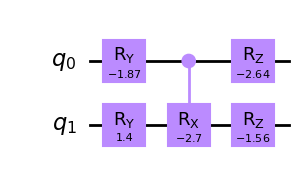

Statevector (almost eigevector) [-0.23 +0.394j -0.376-0.361j  0.327+0.198j -0.462+0.4j  ]


     fun: 0.2056
    funl: array([0.206, 0.47 ])
 message: 'Optimization terminated successfully.'
    nfev: 128
     nit: 2
   nlfev: 28
   nlhev: 0
   nljev: 3
 success: True
       x: array([-1.462,  2.093, -1.574,  1.33 ,  2.581])
      xl: array([[-1.462,  2.093, -1.574,  1.33 ,  2.581],
       [-1.51 , -1.496,  1.243,  2.489, -1.568]])
Achieved fidelity: 0.7882
Ansatz circuit:


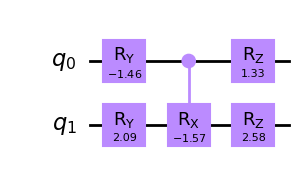

Statevector (almost eigevector) [-0.14 -0.345j -0.431-0.194j  0.522+0.377j  0.373-0.289j]


     fun: 0.138
    funl: array([0.138, 0.265, 0.387, 0.462])
 message: 'Optimization terminated successfully.'
    nfev: 172
     nit: 2
   nlfev: 72
   nlhev: 0
   nljev: 7
 success: True
       x: array([ 1.93 , -1.337,  2.132,  1.298,  2.533])
      xl: array([[ 1.93 , -1.337,  2.132,  1.298,  2.533],
       [-1.25 , -1.719, -2.695,  0.828,  1.707],
       [-1.31 ,  2.076, -1.085,  1.811, -2.971],
       [ 1.144,  0.757,  1.629,  3.093, -0.323]])
Achieved fidelity: 0.8592
Ansatz circuit:


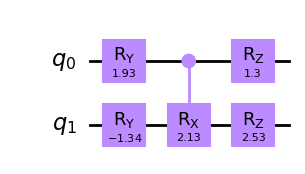

Statevector (almost eigevector) [-0.151-0.421j  0.513+0.183j -0.288-0.205j  0.615-0.041j]




In [5]:
from scipy.optimize import minimize, shgo
from math import pi

best_vector = None
best_fidelity = -1.

for i in range(3):
    # this is the main part of the code
    global_minimum = shgo(
            loss, 
            [(-pi, pi)] * PARAMS_COUNT, 
            sampling_method='halton')
    print(global_minimum)
    
    
    # here is some visualization
    fid = compute_fidelity(global_minimum.x, P)
    print(f"Achieved fidelity: {fid}")
    
    print("Ansatz circuit:")
    qc = QuantumCircuit(2)
    qc.append(_ansatz(global_minimum.x), [0, 1])
    display(qc.decompose().draw('mpl'))
    
    sv = execute(qc, 
                 BasicAer.get_backend('statevector_simulator')
                ).result().get_statevector()
    if best_fidelity < compute_fidelity(global_minimum.x, P):
        best_fidelity = fid
        best_vector = sv
        
    print("Statevector (almost eigevector)", sv)
    print("\n")

### Compare your vector with the precomputed ones.

In [6]:
from qiskit.quantum_info import Statevector

for val, vec in zip(e_values, e_vectors.T):
    from qiskit.quantum_info import state_fidelity, Statevector
    
    fi = state_fidelity(best_vector, Statevector(vec))
    print(f"Fidelity is: {fi:.4f}; corresponding eigenphase: {cmath.phase(val)}")

Fidelity is: 0.0500; corresponding eigenphase: 2.3561944901923457
Fidelity is: 0.9376; corresponding eigenphase: -2.3561944901923453
Fidelity is: 0.0120; corresponding eigenphase: 0.7853981633974483
Fidelity is: 0.0004; corresponding eigenphase: -0.7853981633974483


## QPE: quantum phase estimation

QPE is an algorithm which estimates phase value (in shares of full circle). Apply it to obtain the value of the eigenphase and eigenvalue.

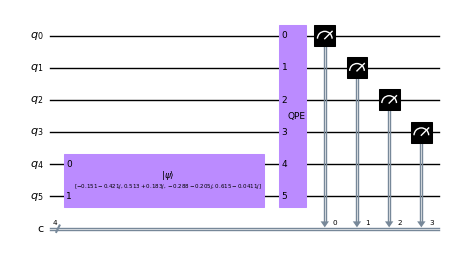

In [7]:
from qiskit.circuit.library import PhaseEstimation
from qiskit.extensions import UnitaryGate

PRECISION = 4

qc = QuantumCircuit(PRECISION + 2, PRECISION)

# TODO: implemend a QPE circuit for `best_vector` vector.
# [30] points
qpe = PhaseEstimation(PRECISION, UnitaryGate(P))
qc.initialize(best_vector, [4, 5])
qc.append(qpe, range(PRECISION + 2))
qc.measure(range(PRECISION), range(PRECISION))

qc.draw('mpl', scale=.5)

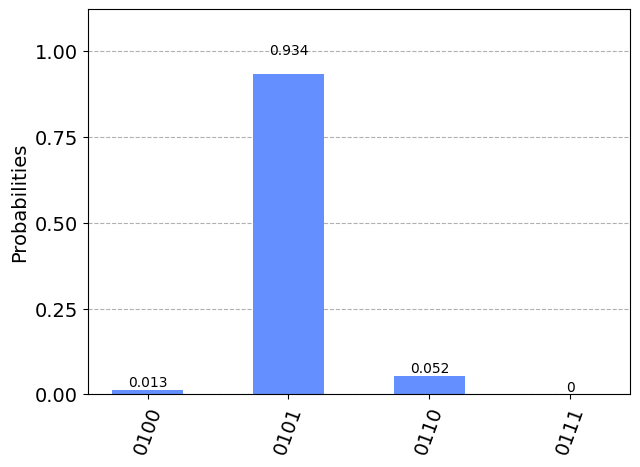

In [8]:
counts = execute(qc, backend, shots=10000).result().get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [9]:
# TODO print the correct extimation of the eigenphase 
# given the results of measurement
# write your code here
# [20] points
print(f"{Fraction(int(sorted(list(counts.items()), key=lambda x: x[1], reverse=True)[0][0], base=2) / 8)}*π")

5/8*π
